In [1]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist



In [2]:
def build_generator(img_size, latent_dim):
    z = Input(shape = (latent_dim))
    x = Dense(128, activation = tf.nn.leaky_relu)(z)
    x = Dense(256, activation = tf.nn.leaky_relu)(x)
    x = Dense(512, activation = tf.nn.leaky_relu)(x)
    x = Dense(1024, activation = tf.nn.leaky_relu)(x)
    x = Dense(img_size)(x)
    return Model(z, x)

def build_encoder(img_size, latent_dim):
    x = Input(shape = (img_size))
    z = Dense(1024, activation = tf.nn.leaky_relu)(x)
    z = Dense(512, activation = tf.nn.leaky_relu)(z)
    z = Dense(256, activation = tf.nn.leaky_relu)(z)
    z = Dense(128, activation = tf.nn.leaky_relu)(z)
    z = Dense(latent_dim)(z)
    return Model(x, z)

def build_discriminator(img_size, latent_dim):
    x = Input(shape=(img_size))
    z = Input(shape=(latent_dim))
    y = Concatenate()([x,z])
    y = Dense(1024, activation = tf.nn.leaky_relu)(y)
    y = Dense(512, activation = tf.nn.leaky_relu)(y)
    y = Dense(256, activation = tf.nn.leaky_relu)(y)
    y = Dense(128, activation = tf.nn.leaky_relu)(y)
    y = Dense(1)(y)
    return Model([x,z], y)


In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
num = X_train.shape[0]

X_train = (X_train.reshape(num,-1)/255.0)*2 - 1
X_test = (X_test.reshape(X_test.shape[0],-1)/255.0)*2 - 1

In [4]:
latent_dim = 100
img_dim = X_train.shape[1]

enc = build_encoder(img_dim, latent_dim)
gen = build_generator(img_dim, latent_dim)
disc = build_discriminator(img_dim, latent_dim)

g_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)
e_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)
d_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)

epochs = 50
batch_size = 128

2023-03-23 16:22:21.447869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 16:22:21.463646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 16:22:21.466713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 16:22:21.471210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
z_train = np.random.uniform(-1,1, (num, latent_dim))

In [6]:
for epoch in tqdm(range(epochs), desc='Total'):
    perm = np.random.permutation(num)
    
    X_train = X_train[perm]
    y_train = y_train[perm]
    z_train = z_train[perm]
    
    running_loss = [0,0,0]
    num_steps = num//batch_size
    
    for steps in range(0, num_steps):
        x_batch = X_train[batch_size*(steps):batch_size*(steps+1)]
        z_batch = z_train[batch_size*(steps):batch_size*(steps+1)]
        y_batch = y_train[batch_size*(steps):batch_size*(steps+1)]
        
        with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:      
            fake_img = gen(z_batch)
            fake_z = enc(x_batch)

            preds = disc([tf.concat([fake_img, x_batch], axis = 0) , tf.concat([z_batch, fake_z], axis = 0)])
            pred_gen, pred_enc = tf.split(preds, 2)
            
            gen_loss = tf.reduce_mean(tf.nn.softplus(-pred_gen))
            enc_loss = tf.reduce_mean(tf.nn.softplus(pred_enc))
            disc_loss = tf.reduce_mean(tf.nn.softplus(pred_gen)) + tf.reduce_mean(tf.nn.softplus(-pred_enc))

        gen_grad = tape.gradient(gen_loss, gen.trainable_variables)
        disc_grad = tape.gradient(disc_loss, disc.trainable_variables)
        enc_grad = tape.gradient(enc_loss, enc.trainable_variables)

        g_opt.apply_gradients(zip(gen_grad,gen.trainable_variables))
        e_opt.apply_gradients(zip(enc_grad,enc.trainable_variables))
        d_opt.apply_gradients(zip(disc_grad,disc.trainable_variables))

        running_loss[0] += disc_loss.numpy()
        running_loss[1] += gen_loss.numpy()
        running_loss[2] += enc_loss.numpy()
        del tape
    print('[{}] Desc loss : {:.10f}\t Gen Loss : {:.10f}\t Enc Loss : {:.10f}'.format(epoch,running_loss[0],running_loss[1], running_loss[2] ))

Total:   0%|          | 0/50 [00:00<?, ?it/s]

[0] Desc loss : 509.8605464399	 Gen Loss : 390.5054256469	 Enc Loss : 865.3867361248
[1] Desc loss : 472.2768166661	 Gen Loss : 506.5561241880	 Enc Loss : 1239.5430729091
[2] Desc loss : 567.1183400154	 Gen Loss : 500.6371033937	 Enc Loss : 927.4778459966
[3] Desc loss : 572.6511877775	 Gen Loss : 555.6390603632	 Enc Loss : 807.0550187528
[4] Desc loss : 571.4469037056	 Gen Loss : 542.1464429200	 Enc Loss : 769.0749910474
[5] Desc loss : 537.2279810309	 Gen Loss : 572.0343555361	 Enc Loss : 766.5914123654
[6] Desc loss : 557.8818193078	 Gen Loss : 561.3853897005	 Enc Loss : 666.3255690932
[7] Desc loss : 564.5022831559	 Gen Loss : 561.5510781109	 Enc Loss : 615.8259807825
[8] Desc loss : 538.5625317693	 Gen Loss : 565.6951207817	 Enc Loss : 699.7799848914
[9] Desc loss : 535.0071919560	 Gen Loss : 568.1917245090	 Enc Loss : 667.5099419951
[10] Desc loss : 539.9578737617	 Gen Loss : 570.4217926860	 Enc Loss : 686.6074838936
[11] Desc loss : 520.4464271069	 Gen Loss : 581.0649401844	 Enc

1/1 [==============================] - 0s 19ms/step


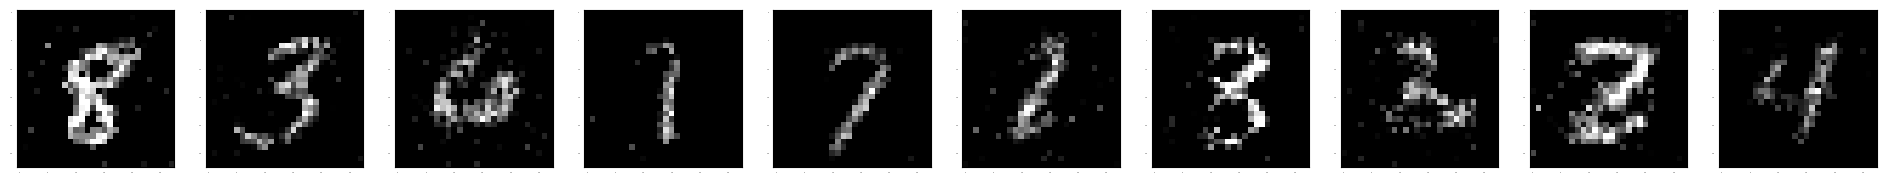

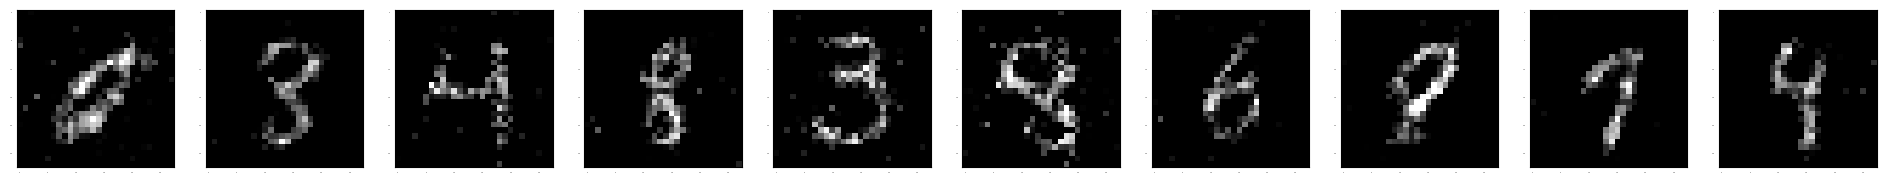

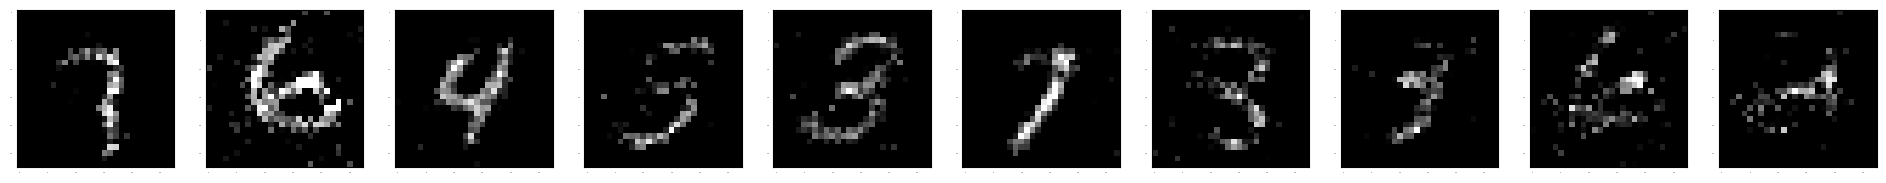

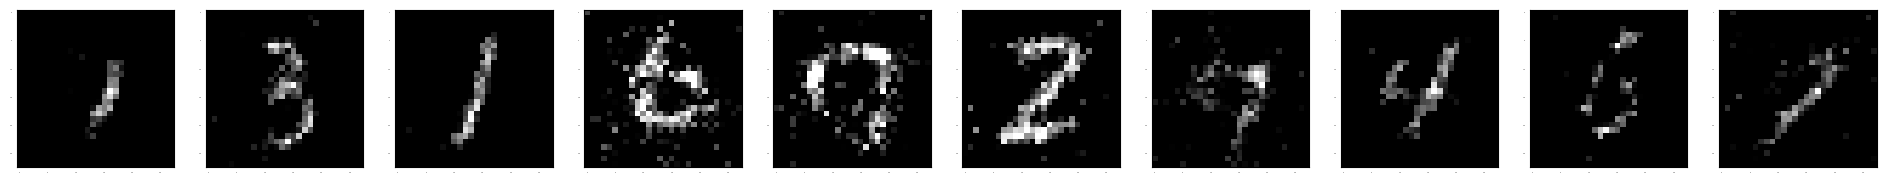

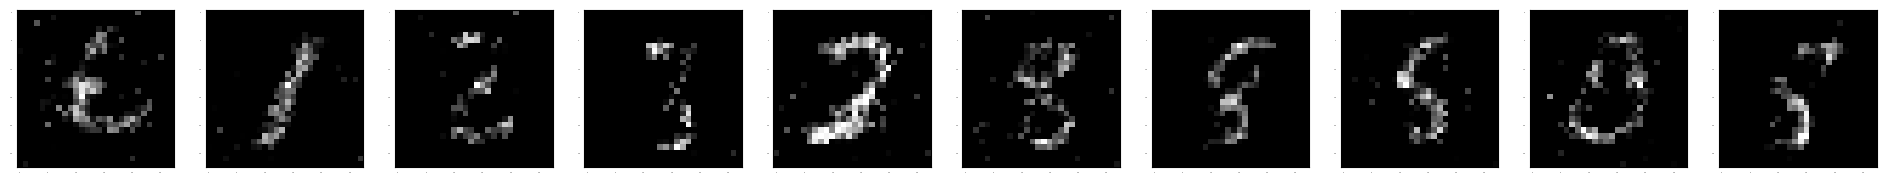

In [7]:
for _ in range(5):
    num_sample = 10
    z_test = np.random.uniform(-1,1, (num, latent_dim))
    pred = gen.predict(z_test[:num_sample]).reshape(-1,28,28)

    _, axs = plt.subplots(1,num_sample, figsize=(24,12))
    for i in range(num_sample):
        axs[i].imshow(np.clip((pred[i])*(255.0/2), 0, 255), cmap = 'gray')
        axs[i].tick_params(length=0, labelsize=0)